# CSX46 Class Notebook 4 - Local Clustering Coefficient

In this class session we are going to compute the local clustering coefficient of all vertices in the undirected human
protein-protein interaction network (PPI), in two ways -- first without using `igraph`, and the using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder), we'll make an "adjacency forest" representation of the network, and we'll manually compute the local clustering coefficient of each vertex (protein) in the network using the "enumerating neighbor pairs" method described by Newman. Then we'll run the same algorithm using the `transitivity_local_undirected` function in `igraph`, and we'll compare the results in order to check our work.  Grad students:  you should also group vertices by their "binned" vertex degree k (bin size 50, total number of bins = 25) and plot the average local clustering coefficient for the vertices within a bin, against the center k value for the bin, on log-log scale (compare to Newman Fig. 8.12)

For this notebook, we will need cairo, igraph, pandas, numpy, timeit, pympler.asizeof, bintrees, and matplotlib. The packages `bintrees` and `pympler` must be installed using pip before they can be imported. For bintrees, you can look at the code in the class02 notebook. For pympler, the PyPI package name is `pympler` and the python import is `pympler.asizeof`.


Remember, to install `bintrees`, you need to add the `--only-binary=:all:` directive to `pip`.

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install cython
!pip install python-igraph pympler
!pip install --only-binary=:all: bintrees
import cairo, igraph, pandas, numpy, timeit, pympler.asizeof, bintrees, matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgif-dev is already the newest version (5.1.9-2build2).
libgif-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu10).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin libice-dev
  liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev
  libxml2-utils libice-doc libsm-doc
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxcb-render0-dev libxcb-shm0-dev
0 upgrad

Download the Pathway Commons 2 SIF file and uncompress it (see Part 2 of the notebook from Class Session 1)

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz --output PathwayCommons9.All.hgnc.sif.gz
!gunzip -f PathwayCommons9.All.hgnc.sif.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5930k  100 5930k    0     0  5308k      0  0:00:01  0:00:01 --:--:-- 5314k


Step 1:  load in the SIF file (refer to Class 3 exercise) into a data frame `sif_data`, using the `pandas.read_csv` function, and name the columns `species1`, `interaction_type`, and `species2`.

In [ ]:
sif_data = pandas.read_csv("PathwayCommons9.All.hgnc.sif",
                           sep="\t", names=["species1", "interaction_type", "species2"])

Step 2:  restrict the interactions to protein-protein undirected interactions (specifically, restrict to rows where the `interaction_type` column value is in the set `{"in-complex-with", "interacts-with"}`), by using the `isin` method and then using `[` to index rows into the data frame.  Call the returned ata frame `interac_ppi`.

In [ ]:
interaction_types_ppi = {"interacts-with", "in-complex-with"}
interac_ppi = sif_data[sif_data.interaction_type.isin(interaction_types_ppi)]

Step 3: restrict the data frame to only the unique interaction pairs of proteins (ignoring the interaction type), and call that data frame `interac_ppi_unique`. Make an igraph `Graph` object from `interac_ppi_unique` using `Graph.TupleList`, `values`, and `tolist`. Call `summary` on the `Graph` object. Refer to the notebooks for the in-class exercises in Class sessions 3 and 6.

In [ ]:
boolean_vec = interac_ppi['species1'] > interac_ppi['species2']
interac_ppi.loc[boolean_vec, ['species1', 'species2']] = interac_ppi.loc[boolean_vec, ['species2', 'species1']].values
interac_ppi.head()

<ipython-input-5-67f1730c0468>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interac_ppi.loc[boolean_vec, ['species1', 'species2']] = interac_ppi.loc[boolean_vec, ['species2', 'species1']].values


,species1,interaction_type,species2
1,A1BG,interacts-with,ABCC6
2,A1BG,interacts-with,ACE2
3,A1BG,interacts-with,ADAM10
4,A1BG,interacts-with,ADAM17
5,A1BG,interacts-with,ADAM9


In [ ]:
interac_ppi_unique = interac_ppi[["species1","species2"]].drop_duplicates()

ppi_igraph = igraph.Graph.TupleList(interac_ppi_unique.values.tolist(), directed=False)
igraph.summary(ppi_igraph)

IGRAPH UN-- 17531 475553 -- 
+ attr: name (v)


Step 4: Obtain an adjacency list representation of the graph (refer to Class 2 notebooks), using the `igraph.Graph.get_adjlist` method.

In [ ]:
ppi_adj_list = ppi_igraph.get_adjlist()

Step 5: You can get a count *n* of the vertices in the graph by calling `len` on `ppi_adj_list`. Call this adjacency forest, `ppi_adj_forest`. Make an "adjacency forest" data structure as a list of *n* `AVLTree` objects (refer to Class 2c exercise).

In [ ]:
def get_bst_forest(theadjlist):
    g_adj_list = theadjlist
    n = len(g_adj_list)
    theforest = []
    for i in range(0,n):
        itree = bintrees.AVLTree()
        for j in g_adj_list[i]:
            itree.insert(j,1)
        theforest.append(itree)
    return theforest

def find_bst_forest(bst_forest, i, j):
    return j in bst_forest[i]

ppi_adj_forest = get_bst_forest(ppi_adj_list)

Step 6: Compute the local clustering coefficient (C<sub>i</sub>) values of the first 100 vertices (do timing on this operation using the `timeit` package) as a `numpy.array`; for any vertex with degree=1, it's C<sub>i</sub> value can be defined as numpy `NaN`. You'll probably want to have an outer `for` loop for vertex ID `n` going from 0 to 99, and then an inner `for` loop iterating over neighbor vertices of vertex `n`. Store the clustering coefficients in a list `civals`. Print out how many seconds it takes to perform this calculation.

In [ ]:
N = len(ppi_adj_list)
civals = numpy.zeros(100)
civals[:] = numpy.NaN
start_time = timeit.default_timer()
for n in range(0, 100):
    neighbors = ppi_adj_list[n]
    nneighbors = len(neighbors)
    if nneighbors > 1:
        nctr = 0
        for i in range(0, nneighbors):
            for j in range(i + 1, nneighbors):
                if neighbors[j] in ppi_adj_forest[neighbors[i]]:
                    nctr += 1
        civals[n] = nctr/(nneighbors*(nneighbors-1)/2)

ci_elapsed = timeit.default_timer() - start_time
print("%0.2f s" % ci_elapsed)

11.31 s


Step 7: Calculate the local clustering coefficients for the first 100 vertices using
the method `igraph.Graph.transitivity_local_undirected` and save the results as a list `civals_igraph`. Do timing on the call to `transitivity_local_undirected`, using `vertices=` to specify the vertices for which you want to compute the local clustering coefficient.

In [ ]:
start_time = timeit.default_timer()
civals_igraph = ppi_igraph.transitivity_local_undirected(vertices=list(range(0,100)))
ci_elapsed = timeit.default_timer() - start_time
print("%0.2f s" % ci_elapsed)

0.44 s


Why do you think the `igraph` function `transitivity_local_undirected` is so much faster than our Python code above (which uses the adjacency forest representation of the graph)?

Step 8: Compare your C<sub>i</sub> values to those that you got from `igraph`, using a scatter plot where `civals` is on the horizontal axis and `civals_igraph` is on the vertical axis.

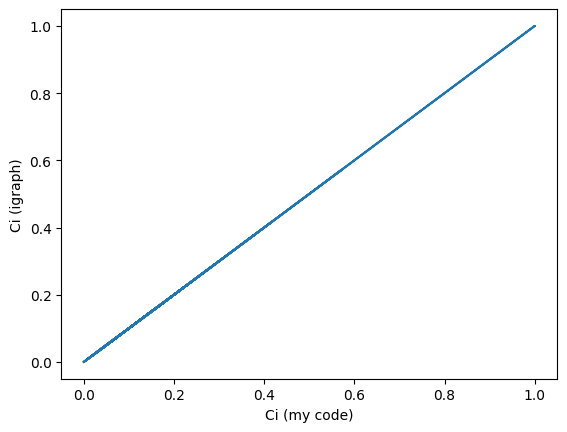

In [ ]:
matplotlib.pyplot.plot(civals, civals_igraph)
matplotlib.pyplot.xlabel("Ci (my code)")
matplotlib.pyplot.ylabel("Ci (igraph)")
matplotlib.pyplot.show()

Step 9:  scatter plot the average log(C<sub>i</sub>) vs. log(k) (i.e., local clustering coefficient vs. vertex degree) for 25 bins of vertex degree, with each bin size being 50 (so we are binning by k, and the bin centers are 50, 100, 150, 200, ...., 1250)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


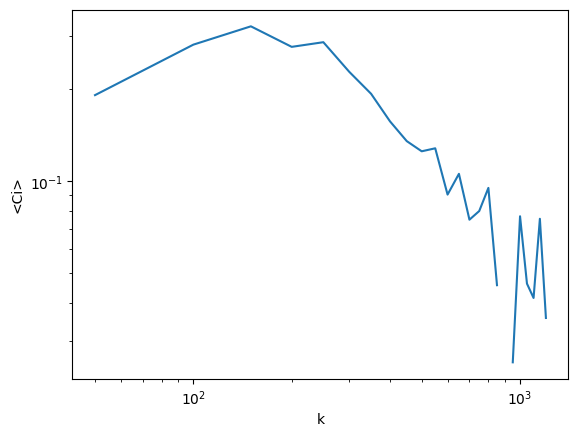

In [ ]:
civals_igraph = numpy.array(ppi_igraph.transitivity_local_undirected())
deg_igraph = ppi_igraph.degree()
deg_npa = numpy.array(deg_igraph)
deg_binids = numpy.rint(deg_npa/50)
binkvals = 50*numpy.array(range(0,25))
civals_avg = [numpy.mean(civals_igraph[deg_binids == j]) for j in range(0, 25)]

matplotlib.pyplot.loglog(
     binkvals,
     civals_avg)
matplotlib.pyplot.ylabel("<Ci>")
matplotlib.pyplot.xlabel("k")
matplotlib.pyplot.show()

Compare the above plot to the same type of plot (from Figure 2 of the Potapov et al. article, left panel) for the human gene regulatory network "TN_RN". Do they have similar asymptotic (large-*k*) behavior?

Step 10: Now try computing the local clustering coefficient for *all* vertices, this time using a "list of hashtables" approach. Estimate how long the same calculation would take using an `AVLTree` adjacency forest, and compare. Which is faster?  Why do you think that is so?

In [ ]:
civals = numpy.zeros(len(ppi_adj_list))
civals[:] = numpy.NaN

ppi_adj_hash = []
for i in range(0, len(ppi_adj_list)):
    newhash = set()
    for j in ppi_adj_list[i]:
        newhash.add(j)
    ppi_adj_hash.append(newhash)


start_time = timeit.default_timer()
for n in range(0, len(ppi_adj_list)):
    neighbors = ppi_adj_hash[n]
    nneighbors = len(neighbors)
    if nneighbors > 1:
        nctr = 0
        for i in neighbors:
            for j in neighbors:
                if (j > i) and (j in ppi_adj_hash[i]):
                    nctr += 1
        civals[n] = nctr/(nneighbors*(nneighbors-1)/2)

ci_elapsed = timeit.default_timer() - start_time
print("%0.2f" % ci_elapsed)

38.78


So the built-in python dictionary type gave us fantastic performance.  But is this coming at the cost of huge memory footprint? Let's check the size of our adjacency "list of hashtables" (`ppi_adj_hash`), in MB:

In [ ]:
pympler.asizeof.asizeof(ppi_adj_hash)/1000000

88.690424

Compare to the size of `ppi_adj_forest`

In [ ]:
pympler.asizeof.asizeof(ppi_adj_forest)/1000000

100.560424